# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

In [2]:
nUS = 8
iS = 1

In [3]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','qrage_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [4]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [5]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/qrage_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_1_8.h5


In [6]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e2

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 1 of 16.


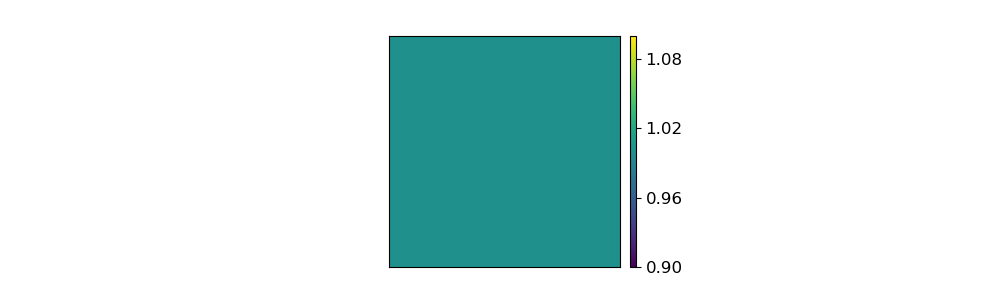

In [7]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

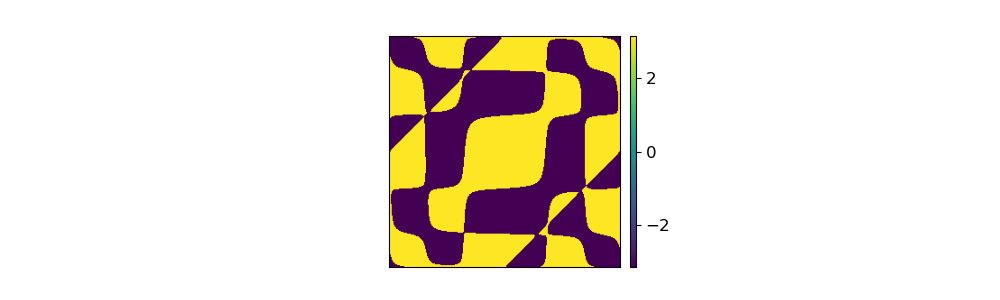

In [8]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [9]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [10]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

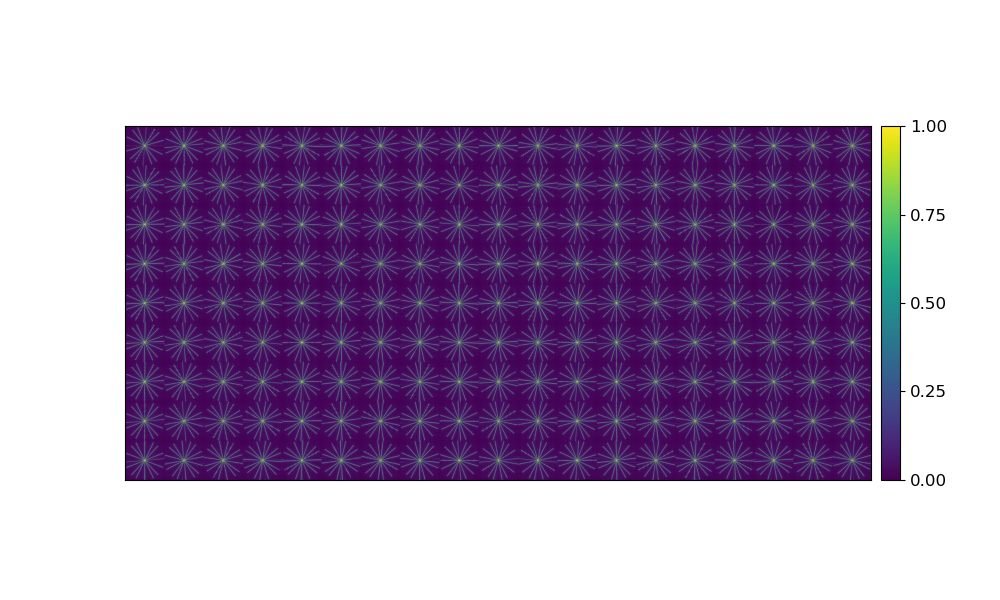

In [11]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

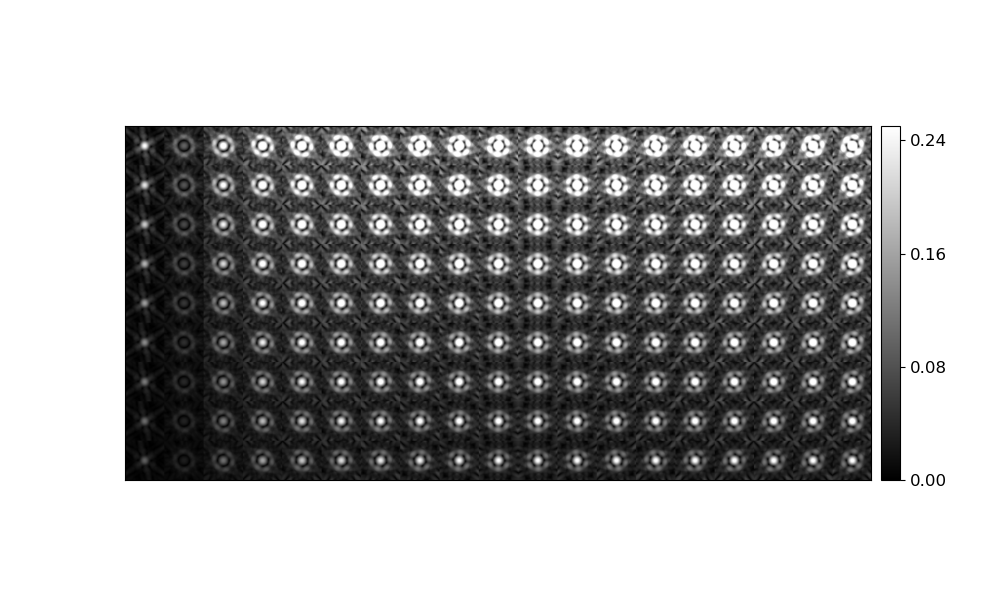

In [12]:
MultiPlotter(
    np.abs(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=0,
    vmax=0.25,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

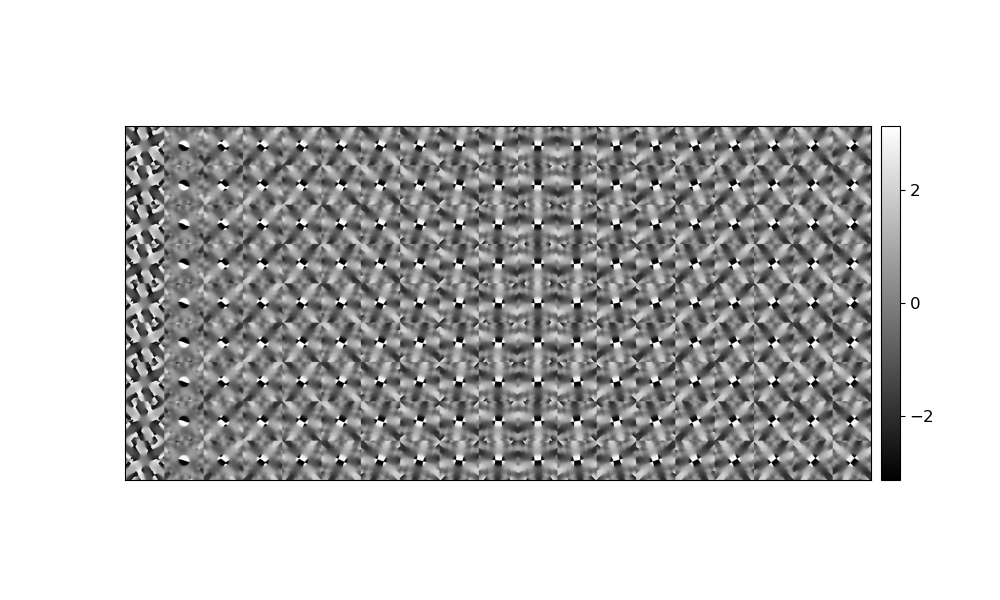

In [13]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [14]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [15]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: 1.61E+02 Dual Res: 1.61E+02 Rel Res: 1.00E+00:   3%|▎         | 1/30 [00:07<03:47,  7.84s/it]

[Convergence Monitor] Norm:  9.982e-01 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: 8.11E+01 Dual Res: 8.25E+01 Rel Res: 9.97E-01:   7%|▋         | 2/30 [00:15<03:28,  7.45s/it]

[Convergence Monitor] Norm:  9.992e-01 	 Time per Iteration:  7.183e+00


[ADMM] Iter: 02 Prim Res: 3.89E+01 Dual Res: 4.50E+01 Rel Res: 9.94E-01:  10%|█         | 3/30 [00:22<03:17,  7.30s/it]

[Convergence Monitor] Norm:  1.000e+00 	 Time per Iteration:  7.117e+00


[ADMM] Iter: 03 Prim Res: 1.99E+01 Dual Res: 2.60E+01 Rel Res: 9.90E-01:  13%|█▎        | 4/30 [00:29<03:07,  7.20s/it]

[Convergence Monitor] Norm:  1.001e+00 	 Time per Iteration:  7.047e+00


[ADMM] Iter: 04 Prim Res: 1.07E+01 Dual Res: 1.60E+01 Rel Res: 9.83E-01:  17%|█▋        | 5/30 [00:36<02:58,  7.16s/it]

[Convergence Monitor] Norm:  1.001e+00 	 Time per Iteration:  7.080e+00


[ADMM] Iter: 05 Prim Res: 5.98E+00 Dual Res: 1.06E+01 Rel Res: 9.74E-01:  20%|██        | 6/30 [00:43<02:50,  7.12s/it]

[Convergence Monitor] Norm:  1.001e+00 	 Time per Iteration:  7.060e+00


[ADMM] Iter: 06 Prim Res: 3.49E+00 Dual Res: 7.57E+00 Rel Res: 9.64E-01:  23%|██▎       | 7/30 [00:50<02:43,  7.09s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.024e+00


[ADMM] Iter: 07 Prim Res: 2.12E+00 Dual Res: 5.85E+00 Rel Res: 9.56E-01:  27%|██▋       | 8/30 [00:57<02:35,  7.09s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.083e+00


[ADMM] Iter: 08 Prim Res: 1.35E+00 Dual Res: 4.82E+00 Rel Res: 9.48E-01:  30%|███       | 9/30 [01:04<02:28,  7.08s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.074e+00


[ADMM] Iter: 09 Prim Res: 9.05E-01 Dual Res: 4.15E+00 Rel Res: 9.41E-01:  33%|███▎      | 10/30 [01:11<02:21,  7.07s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.032e+00


[ADMM] Iter: 10 Prim Res: 6.39E-01 Dual Res: 3.69E+00 Rel Res: 9.35E-01:  37%|███▋      | 11/30 [01:18<02:14,  7.07s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.068e+00


[ADMM] Iter: 11 Prim Res: 4.75E-01 Dual Res: 3.35E+00 Rel Res: 9.29E-01:  40%|████      | 12/30 [01:25<02:07,  7.06s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.035e+00


[ADMM] Iter: 12 Prim Res: 3.68E-01 Dual Res: 3.10E+00 Rel Res: 9.23E-01:  43%|████▎     | 13/30 [01:32<02:00,  7.08s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.134e+00


[ADMM] Iter: 13 Prim Res: 2.95E-01 Dual Res: 2.89E+00 Rel Res: 9.17E-01:  47%|████▋     | 14/30 [01:39<01:53,  7.11s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.180e+00


[ADMM] Iter: 14 Prim Res: 2.43E-01 Dual Res: 2.73E+00 Rel Res: 9.12E-01:  50%|█████     | 15/30 [01:47<01:46,  7.12s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.140e+00


[ADMM] Iter: 15 Prim Res: 2.05E-01 Dual Res: 2.60E+00 Rel Res: 9.06E-01:  53%|█████▎    | 16/30 [01:54<01:39,  7.11s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.080e+00


[ADMM] Iter: 16 Prim Res: 1.75E-01 Dual Res: 2.49E+00 Rel Res: 9.01E-01:  57%|█████▋    | 17/30 [02:01<01:32,  7.14s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.216e+00


[ADMM] Iter: 17 Prim Res: 1.51E-01 Dual Res: 2.39E+00 Rel Res: 8.96E-01:  60%|██████    | 18/30 [02:08<01:25,  7.12s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.090e+00


[ADMM] Iter: 18 Prim Res: 1.32E-01 Dual Res: 2.32E+00 Rel Res: 8.92E-01:  63%|██████▎   | 19/30 [02:15<01:18,  7.11s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.083e+00


[ADMM] Iter: 19 Prim Res: 1.16E-01 Dual Res: 2.25E+00 Rel Res: 8.87E-01:  67%|██████▋   | 20/30 [02:22<01:11,  7.10s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.083e+00


[ADMM] Iter: 20 Prim Res: 1.03E-01 Dual Res: 2.19E+00 Rel Res: 8.83E-01:  70%|███████   | 21/30 [02:29<01:04,  7.12s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.164e+00


[ADMM] Iter: 21 Prim Res: 9.13E-02 Dual Res: 2.14E+00 Rel Res: 8.79E-01:  73%|███████▎  | 22/30 [02:36<00:56,  7.12s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.132e+00


[ADMM] Iter: 22 Prim Res: 8.16E-02 Dual Res: 2.09E+00 Rel Res: 8.75E-01:  77%|███████▋  | 23/30 [02:44<00:49,  7.11s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.088e+00


[ADMM] Iter: 23 Prim Res: 7.34E-02 Dual Res: 2.05E+00 Rel Res: 8.72E-01:  80%|████████  | 24/30 [02:51<00:42,  7.13s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.177e+00


[ADMM] Iter: 24 Prim Res: 6.61E-02 Dual Res: 2.02E+00 Rel Res: 8.69E-01:  83%|████████▎ | 25/30 [02:58<00:35,  7.17s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.269e+00


[ADMM] Iter: 25 Prim Res: 5.98E-02 Dual Res: 1.98E+00 Rel Res: 8.65E-01:  87%|████████▋ | 26/30 [03:05<00:28,  7.19s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.240e+00


[ADMM] Iter: 26 Prim Res: 5.43E-02 Dual Res: 1.95E+00 Rel Res: 8.62E-01:  90%|█████████ | 27/30 [03:12<00:21,  7.22s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.271e+00


[ADMM] Iter: 27 Prim Res: 4.95E-02 Dual Res: 1.93E+00 Rel Res: 8.60E-01:  93%|█████████▎| 28/30 [03:20<00:14,  7.20s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.171e+00


[ADMM] Iter: 28 Prim Res: 4.52E-02 Dual Res: 1.90E+00 Rel Res: 8.57E-01:  97%|█████████▋| 29/30 [03:27<00:07,  7.22s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.249e+00


[ADMM] Iter: 29 Prim Res: 4.15E-02 Dual Res: 1.88E+00 Rel Res: 8.54E-01: 100%|██████████| 30/30 [03:34<00:00,  7.16s/it]

[Convergence Monitor] Norm:  1.002e+00 	 Time per Iteration:  7.274e+00


tensor([ 0.0072, -0.1398,  0.0104,  ...,  0.2399,  0.0079, -0.1991])

In [16]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_997/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


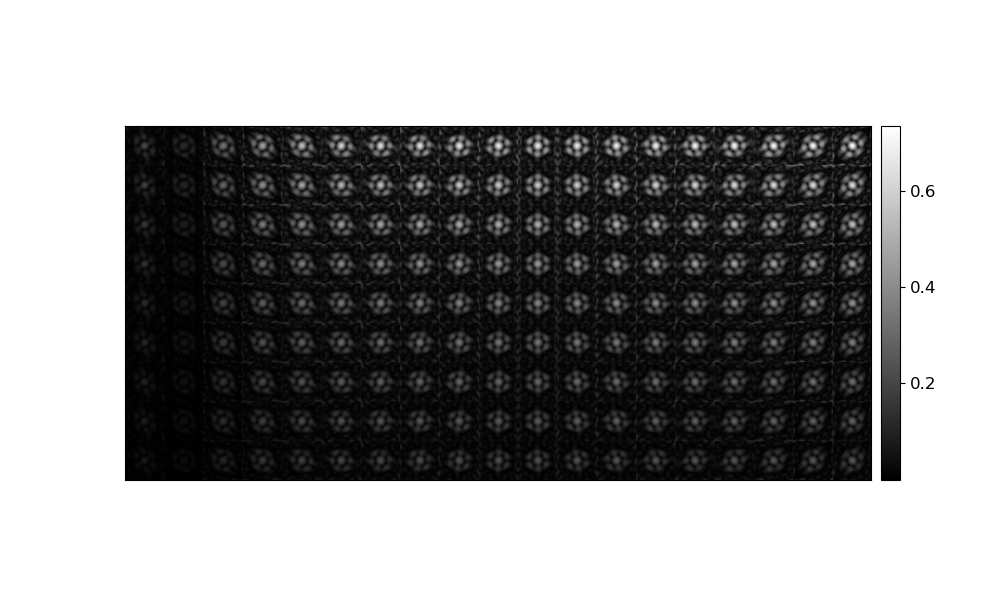

In [17]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [18]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [19]:
plt.savefig(os.path.join(filepath, 'reconstruction_idea.png'), dpi=1200, transparent=True)